Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19.000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'http://yaroslavvb.com/upload/notMNIST/'

def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
    print (filename)
    print (_)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large\\A', 'notMNIST_large\\B', 'notMNIST_large\\C', 'notMNIST_large\\D', 'notMNIST_large\\E', 'notMNIST_large\\F', 'notMNIST_large\\G', 'notMNIST_large\\H', 'notMNIST_large\\I', 'notMNIST_large\\J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small\\A', 'notMNIST_small\\B', 'notMNIST_small\\C', 'notMNIST_small\\D', 'notMNIST_small\\E', 'notMNIST_small\\F', 'notMNIST_small\\G', 'notMNIST_small\\H', 'notMNIST_small\\I', 'notMNIST_small\\J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [4]:
img = Image(filename="notMNIST_large/C/a2F6b28udHRm.png")
display(img)

First of all, let's import some libraries that I will use later on and activate online display of matplotlib outputs:

In [5]:
import random
import hashlib
%matplotlib inline

In [6]:
def disp_samples(data_folders, sample_size):
  for folder in data_folders:
    print(folder)
    image_files = os.listdir(folder)
    image_sample = random.sample(image_files, sample_size)
    for image in image_sample:
      image_file = os.path.join(folder, image)
      i = Image(filename=image_file)
      display(i)

In [7]:
disp_samples(train_folders, 6)

notMNIST_large\A


notMNIST_large\B


notMNIST_large\C


notMNIST_large\D


notMNIST_large\E


notMNIST_large\F


notMNIST_large\G


notMNIST_large\H


notMNIST_large\I


notMNIST_large\J


In [8]:
disp_samples(test_folders, 2)

notMNIST_small\A


notMNIST_small\B


notMNIST_small\C


notMNIST_small\D


notMNIST_small\E


notMNIST_small\F


notMNIST_small\G


notMNIST_small\H


notMNIST_small\I


notMNIST_small\J


Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [9]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  image_index = 0
  print(folder)
  for image in os.listdir(folder):
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[image_index, :, :] = image_data
      image_index += 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  num_images = image_index
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

notMNIST_large\A.pickle already present - Skipping pickling.
notMNIST_large\B.pickle already present - Skipping pickling.
notMNIST_large\C.pickle already present - Skipping pickling.
notMNIST_large\D.pickle already present - Skipping pickling.
notMNIST_large\E.pickle already present - Skipping pickling.
notMNIST_large\F.pickle already present - Skipping pickling.
notMNIST_large\G.pickle already present - Skipping pickling.
notMNIST_large\H.pickle already present - Skipping pickling.
notMNIST_large\I.pickle already present - Skipping pickling.
notMNIST_large\J.pickle already present - Skipping pickling.
notMNIST_small\A.pickle already present - Skipping pickling.
notMNIST_small\B.pickle already present - Skipping pickling.
notMNIST_small\C.pickle already present - Skipping pickling.
notMNIST_small\D.pickle already present - Skipping pickling.
notMNIST_small\E.pickle already present - Skipping pickling.
notMNIST_small\F.pickle already present - Skipping pickling.
notMNIST_small\G.pickle 

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

notMNIST_large\J.pickle


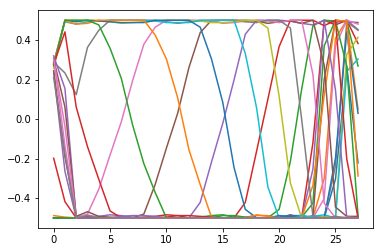

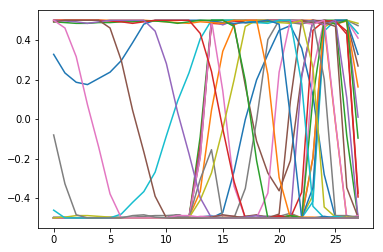

notMNIST_large\F.pickle


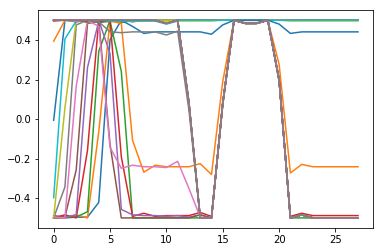

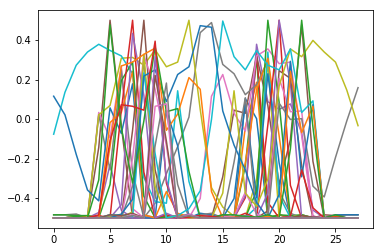

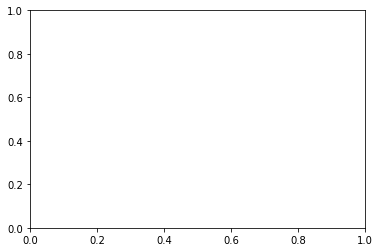

In [13]:
train_datasets

sample_size=2
for fname in random.sample(train_datasets,2):
    print(fname)
    with open (fname, "rb") as f:
        a_data = pickle.load(f)
    samples = random.sample(a_data.tolist(),sample_size)
    for sample in samples:
        p = plt.plot(sample)
        plt.show()
        plt.cla()

In [17]:
def disp_8_img(imgs, titles):
  """Display subplot with 8 images or less"""
  for i, img in enumerate(imgs):
    plt.subplot(2, 4, i+1)
    plt.title(titles[i])
    plt.axis('off')
    plt.imshow(img)

def disp_sample_pickles(data_folders):
  folder = ''.join(random.sample(data_folders, 1))
  pickle_filename = folder + '.pickle'
  try:
    with open(pickle_filename, 'rb') as f:
      dataset = pickle.load(f)
  except Exception as e:
    print('Unable to read data from', pickle_filename, ':', e)
    return
  # display
  plt.suptitle(folder[-1])
  for i, img in enumerate(random.sample(list(dataset), 8)):
    plt.subplot(2, 4, i+1)
    plt.axis('off')
    plt.imshow(img)

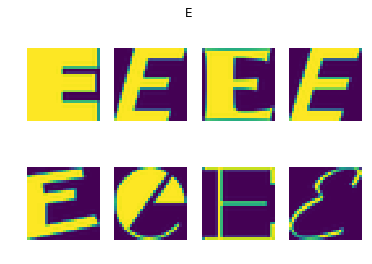

In [18]:
disp_sample_pickles(train_folders)

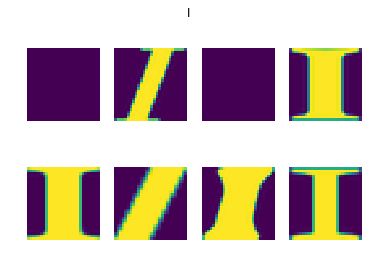

In [19]:
disp_sample_pickles(test_folders)

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

Data is balanced across classes if the classes have about the same number of items. Let's check the number of images by class.

In [20]:
def disp_number_images(data_folders):
  for folder in data_folders:
    pickle_filename = ''.join(folder) + '.pickle'
    try:
      with open(pickle_filename, 'rb') as f:
        dataset = pickle.load(f)
    except Exception as e:
      print('Unable to read data from', pickle_filename, ':', e)
      return
    print('Number of images in ', folder, ' : ', len(dataset))
    
disp_number_images(train_folders)
disp_number_images(test_folders) 

Number of images in  notMNIST_large\A  :  52909
Number of images in  notMNIST_large\B  :  52911
Number of images in  notMNIST_large\C  :  52912
Number of images in  notMNIST_large\D  :  52911
Number of images in  notMNIST_large\E  :  52912
Number of images in  notMNIST_large\F  :  52912
Number of images in  notMNIST_large\G  :  52912
Number of images in  notMNIST_large\H  :  52912
Number of images in  notMNIST_large\I  :  52912
Number of images in  notMNIST_large\J  :  52911
Number of images in  notMNIST_small\A  :  1872
Number of images in  notMNIST_small\B  :  1873
Number of images in  notMNIST_small\C  :  1873
Number of images in  notMNIST_small\D  :  1873
Number of images in  notMNIST_small\E  :  1873
Number of images in  notMNIST_small\F  :  1872
Number of images in  notMNIST_small\G  :  1872
Number of images in  notMNIST_small\H  :  1872
Number of images in  notMNIST_small\I  :  1872
Number of images in  notMNIST_small\J  :  1872


There are only minor gaps, so the classes are well balanced.

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [21]:
def make_arrays(nb_rows, img_size):
  """
  make_Arrays splits a 3d array into 
  """
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class + tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [22]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

To be sure that the data are still fine after the merger and the randomization, I will select one item and display the image alongside the label. Note: 0 = A, 1 = B, 2 = C, 3 = D, 4 = E, 5 = F, 6 = G, 7 = H, 8 = I, 9 = J. 

In [23]:
pretty_labels = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J'}

def disp_sample_dataset(dataset, labels):
  items = random.sample(range(len(labels)), 8)
  for i, item in enumerate(items):
    plt.subplot(2, 4, i+1)
    plt.axis('off')
    plt.title(pretty_labels[labels[item]])
    plt.imshow(dataset[item])

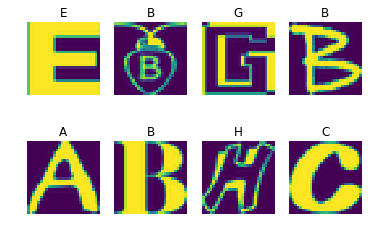

In [24]:
disp_sample_dataset(train_dataset, train_labels)

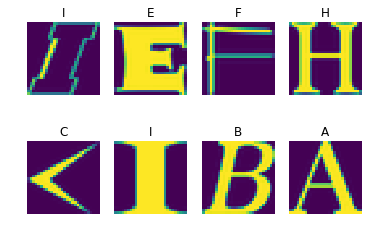

In [27]:
disp_sample_dataset(valid_dataset, valid_labels)

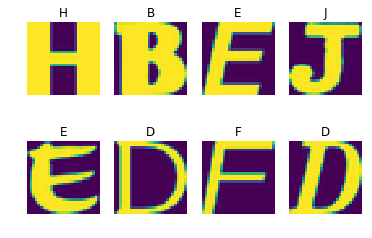

In [29]:
disp_sample_dataset(test_dataset, test_labels)

Finally, let's save the data for later reuse:

In [30]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [32]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800506


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In this part, I will explore the datasets and understand better the overlap cases. There are overlaps, but there are also duplicates in the same dataset! Processing time is also critical. I will first use nested loops and matrix comparison, which is slow and then use hash function to accelerate and process the whole dataset.

In [37]:
def display_overlap(overlap, source_dataset, target_dataset):
  item = random.choice(list(overlap.keys()))
  imgs = np.concatenate(([source_dataset[item]], target_dataset[overlap[item][0:7]]))
  plt.suptitle(item)
  for i, img in enumerate(imgs):
    plt.subplot(2, 4, i+1)
    plt.axis('off')
    plt.imshow(img)

In [38]:
def extract_overlap(dataset_1, dataset_2):
  overlap = {}
  for i, img_1 in enumerate(dataset_1):
    for j, img_2 in enumerate(dataset_2):     
      if np.array_equal(img_1, img_2):
        if not i in overlap.keys():
          overlap[i] = []
        overlap[i].append(j)
  return overlap

In [35]:
%time overlap_test_train = extract_overlap(test_dataset[:200], train_dataset)

Wall time: 2min 14s


Number of overlaps: 24


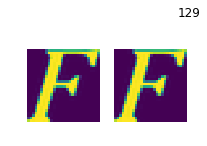

In [63]:
print('Number of overlaps:', len(overlap_test_train.keys()))
display_overlap(overlap_test_train, test_dataset[:200], train_dataset)

The ``display_overlap`` function above displays one of the duplicate, the first element is from the first dataset, and the next ones are from the dataset used for the comparison.

Now that exact duplicates have been found, let's look for near duplicates. How to define near identical images? That's a tricky question. My first thought has been to use the ``allclose`` numpy matrix comparison. This is too restrictive, since two images can vary by one pyxel, and still be very similar even if the variation on the pyxel is large. A better solution involves some kind of average. 

To keep it simple and still relevant, I will use a Manhattan norm (sum of absolute values) of the difference matrix. Since the images of the dataset have all the same size, I will not normalize the norm value. Note that it is pyxel by pyxel comparison, and therefore it will not scale to the whole dataset, but it will help to understand image similarities.

In [64]:
MAX_MANHATTAN_NORM = 10

def extract_overlap_near(dataset_1, dataset_2):
  overlap = {}
  for i, img_1 in enumerate(dataset_1):
    for j, img_2 in enumerate(dataset_2):
      diff = img_1 - img_2
      m_norm = np.sum(np.abs(diff))
      if m_norm < MAX_MANHATTAN_NORM:
        if not i in overlap.keys():
          overlap[i] = []
        overlap[i].append(j)
  return overlap

In [65]:
%time overlap_test_train_near = extract_overlap_near(test_dataset[:200], train_dataset)

Wall time: 4min 26s


Number of near overlaps: 53


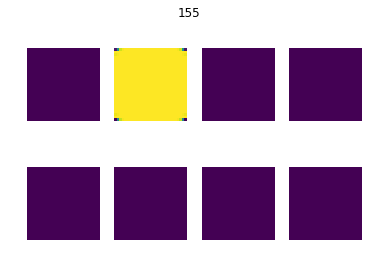

In [82]:
print('Number of near overlaps:', len(overlap_test_train_near.keys()))
display_overlap(overlap_test_train_near, test_dataset[:200], train_dataset)

The techniques above work well, but the performance is very low and the methods are poorly scalable to the full dataset. Let's try to improve the performance. Let's take some reference times on a small dataset.

Here are some ideas:
+ stop a the first occurence
+ nympy function ``where`` in diff dataset
+ hash comparison

In [83]:
def extract_overlap_stop(dataset_1, dataset_2):
  overlap = {}
  for i, img_1 in enumerate(dataset_1):
    for j, img_2 in enumerate(dataset_2):     
      if np.array_equal(img_1, img_2):
        overlap[i] = [j]
        break
  return overlap

In [84]:
%time overlap_test_train = extract_overlap_stop(test_dataset[:200], train_dataset)

Wall time: 2min 3s


Number of overlaps: 24


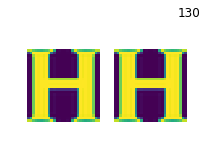

In [85]:
print('Number of overlaps:', len(overlap_test_train.keys()))
display_overlap(overlap_test_train, test_dataset[:200], train_dataset)

It is a faster, and only one duplicate from the second dataset is displayed. This is still not scalable.

In [86]:
MAX_MANHATTAN_NORM = 10

def extract_overlap_where(dataset_1, dataset_2):
  overlap = {}
  for i, img_1 in enumerate(dataset_1):
    diff = dataset_2 - img_1
    norm = np.sum(np.abs(diff), axis=1)
    duplicates = np.where(norm < MAX_MANHATTAN_NORM)
    if len(duplicates[0]):
      overlap[i] = duplicates[0]
  return overlap

In [87]:
test_flat = test_dataset.reshape(test_dataset.shape[0], 28 * 28)
train_flat = train_dataset.reshape(train_dataset.shape[0], 28 * 28)
%time overlap_test_train = extract_overlap_where(test_flat[:200], train_flat)

Wall time: 2min 32s


Number of overlaps: 53


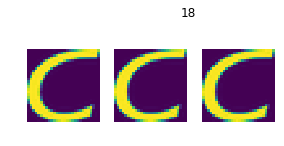

In [100]:
print('Number of overlaps:', len(overlap_test_train.keys()))
display_overlap(overlap_test_train, test_dataset[:200], train_dataset)

The built-in numpy function provides some improvement either, but this algorithm is still not scalable to the dataset to its full extend.

To make it work at scale, the best option is to use a hash function. To find exact duplicates, the hash functions used for the cryptography will work just fine.

In [102]:
def extract_overlap_hash(dataset_1, dataset_2):
  dataset_hash_1 = [hashlib.sha256(img).hexdigest() for img in dataset_1]
  dataset_hash_2 = [hashlib.sha256(img).hexdigest() for img in dataset_2]
  overlap = {}
  for i, hash1 in enumerate(dataset_hash_1):
    for j, hash2 in enumerate(dataset_hash_2):
      if hash1 == hash2:
        if not i in overlap.keys():
          overlap[i] = []
        overlap[i].append(j) ## use np.where
  return overlap

In [118]:
%time overlap_test_train = extract_overlap_hash(test_dataset[:200], train_dataset)

Wall time: 5.52 s


Number of overlaps: 24


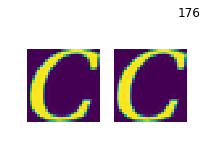

In [127]:
print('Number of overlaps:', len(overlap_test_train.keys()))
display_overlap(overlap_test_train, test_dataset[:200], train_dataset)

More overlapping values could be found, this is due to the hash collisions. Several images can have the same hash but are actually different differents. This is not noticed here, and even if it happens, this is acceptable. All duplicates will be removed for sure.

We can make the processing a bit faster by using the built-in numpy ``where``function.

In [128]:
def extract_overlap_hash_where(dataset_1, dataset_2):
  dataset_hash_1 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_1])
  dataset_hash_2 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_2])
  overlap = {}
  for i, hash1 in enumerate(dataset_hash_1):
    duplicates = np.where(dataset_hash_2 == hash1)
    if len(duplicates[0]):
      overlap[i] = duplicates[0]
  return overlap

In [130]:
%time overlap_test_train = extract_overlap_hash_where(test_dataset[:200], train_dataset)

Wall time: 3.66 s


Number of overlaps: 24


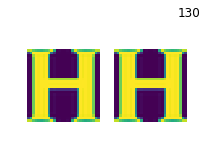

In [131]:
print('Number of overlaps:', len(overlap_test_train.keys()))
display_overlap(overlap_test_train, test_dataset[:200], train_dataset)

From my perspective near duplicates should also be removed in the sanitized datasets. My assumption is that "near" duplicates are very very close (sometimes just there is a one pyxel border of difference), and penalyze the training the same way the true duplicates do.

That's being said, finding near duplicates with a hash function is not obvious. There are techniques for that, like "locally sensitive hashing", "perceptual hashing" or "difference hashing". There even are Python library available. Unfortunatly I did not have time to try them. The sanitized dataset generated below are based on true duplicates found with a cryptography hash function.

For sanitizing the dataset, I change the function above by returning the clean dataset directly.

In [173]:
def sanetize(dataset_1, dataset_2, labels_1):
  dataset_hash_1 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_1])
  dataset_hash_2 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_2])
  overlap = [] # list of indexes
  for i, hash1 in enumerate(dataset_hash_1):
    duplicates = np.where(dataset_hash_2 == hash1)
    if len(duplicates[0]):
      overlap.append(i) 
  return np.delete(dataset_1, overlap, 0), np.delete(labels_1, overlap, None)

In [174]:
%time test_dataset_sanit, test_labels_sanit = sanetize(test_dataset[:200], train_dataset, test_labels[:200])
print('Overlapping images removed: ', len(test_dataset[:200]) - len(test_dataset_sanit))

Wall time: 3.72 s
Overlapping images removed:  24


The same value is found, so we can now sanetize the test and the train datasets.

In [175]:
%time test_dataset_sanit, test_labels_sanit = sanetize(test_dataset, train_dataset, test_labels)
print('Overlapping images removed: ', len(test_dataset) - len(test_dataset_sanit))

Wall time: 39.9 s
Overlapping images removed:  1324


In [176]:
%time valid_dataset_sanit, valid_labels_sanit = sanetize(valid_dataset, train_dataset, valid_labels)
print('Overlapping images removed: ', len(valid_dataset) - len(valid_dataset_sanit))

Wall time: 40.1 s
Overlapping images removed:  1067


In [177]:
pickle_file_sanit = 'notMNIST_sanit.pickle'

try:
  f = open(pickle_file_sanit, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset_sanit,
    'valid_labels': valid_labels_sanit,
    'test_dataset': test_dataset_sanit,
    'test_labels': test_labels_sanit,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [178]:
statinfo = os.stat(pickle_file_sanit)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 683292766


Since I did not have time to generate clean sanitized datasets, I did not use the datasets generated above in the training of the my NN in the next assignments.

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

I have already used scikit-learn in a previous MOOC. It is a great tool, very easy to use!

In [180]:
regr = LogisticRegression()
X_test = test_dataset.reshape(test_dataset.shape[0], 28 * 28)
y_test = test_labels

In [183]:
print(test_dataset.shape)
print(X_test.shape)

(10000, 28, 28)
(10000, 784)


In [186]:
X_test[0]

array([-0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
       -0.4882353 , -0.5       ,  0.10392157,  0.5       ,  0.48431373,
        0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.5       ,
        0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.46470588,
        0.3509804 ,  0.1627451 , -0.10784314, -0.44117647, -0.5       ,
       -0.4882353 , -0.5       , -0.5       , -0.5       , -0.5       ,
       -0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
       -0.04117647,  0.10784314,  0.17843138,  0.5       ,  0.49607843,
        0.5       ,  0.19411765,  0.08431373,  0.10392157,  0.1       ,
        0.13137256,  0.20588236,  0.36666667,  0.5       ,  0.49607843,
        0.5       ,  0.37058824, -0.14705883, -0.5       , -0.4882353 ,
       -0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
       -0.5       , -0.5       , -0.5       , -0.4882353 , -0.5       ,
       -0.1392157 ,  0.5       ,  0.5       ,  0.44117647, -0.41

In [188]:
sample_size = 50
X_train = train_dataset[:sample_size].reshape(sample_size, 784)
y_train = train_labels[:sample_size]
%time regr.fit(X_train, y_train)
regr.score(X_test, y_test)

Wall time: 32.9 ms


0.509

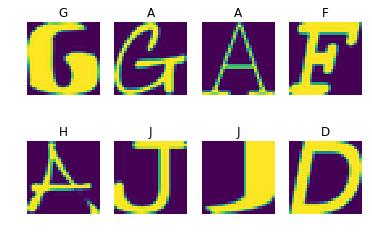

In [205]:
pred_labels = regr.predict(X_test)
disp_sample_dataset(test_dataset, pred_labels)

In [206]:
sample_size = 100
X_train = train_dataset[:sample_size].reshape(sample_size, 784)
y_train = train_labels[:sample_size]
%time regr.fit(X_train, y_train)
regr.score(X_test, y_test)

Wall time: 81.8 ms


0.6966

In [207]:
sample_size = 1000
X_train = train_dataset[:sample_size].reshape(sample_size, 784)
y_train = train_labels[:sample_size]
%time regr.fit(X_train, y_train)
regr.score(X_test, y_test)

Wall time: 1.74 s


0.8333

In [208]:
X_valid = valid_dataset[:sample_size].reshape(sample_size, 784)
y_valid = valid_labels[:sample_size]
regr.score(X_valid, y_valid)

0.736

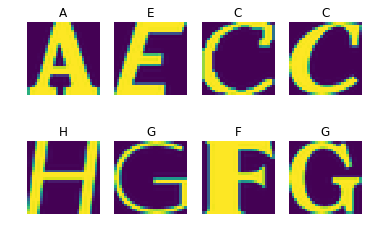

In [212]:
pred_labels = regr.predict(X_valid)
disp_sample_dataset(valid_dataset, pred_labels)

In [213]:
sample_size = 5000
X_train = train_dataset[:sample_size].reshape(sample_size, 784)
y_train = train_labels[:sample_size]
%time regr.fit(X_train, y_train)
regr.score(X_test, y_test)

Wall time: 15.5 s


0.8511

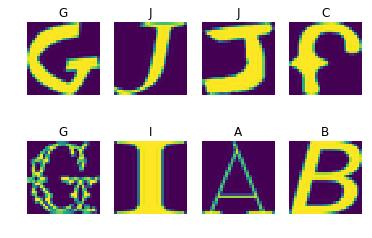

In [214]:
pred_labels = regr.predict(X_valid)
disp_sample_dataset(valid_dataset, pred_labels)

To train the model on all the data, we have to use another solver. SAG is the faster one.

In [ ]:
regr2 = LogisticRegression(solver='sag')
sample_size = len(train_dataset)
X_train = train_dataset[:sample_size].reshape(sample_size, 784)
y_train = train_labels[:sample_size]
%time regr2.fit(X_train, y_train)
regr2.score(X_test, y_test)

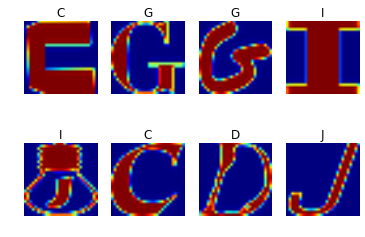

In [55]:
pred_labels = regr.predict(X_test)
disp_sample_dataset(test_dataset, pred_labels)

The accuracy may be weak compared to a deep neural net, but as my first character recognition technique, I find it already impressive!